# CSC 874 Topics in Big Data Fall 2022
**Title: Temporal Orientation Classifier**<br>
**Author: Gian Carlo L. Baldonado**<br>
December 16, 2022



In [568]:
## for data
import json
import pandas as pd
pd.set_option('display.max_colwidth', None)
import numpy as np
from collections import Counter

## for plotting
from matplotlib import pyplot
import seaborn as sns
import matplotlib.pyplot as plt

## for preprocessing and text analysis
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from textblob import TextBlob
from pycorenlp import StanfordCoreNLP


## for word embedding
import gensim
import gensim.downloader as gensim_api
from gensim.models import Word2Vec
import pickle

## model and evaluation
from sklearn import metrics
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn import feature_extraction, model_selection, naive_bayes, manifold, preprocessing, feature_selection
from sklearn.model_selection import train_test_split

## initiate StandordCoreNLP library
## must have package downlaoded and running in background
nlp = StanfordCoreNLP('http://localhost:9000')

## load custom stop words
lst_stopwords = pd.read_csv("./lst_custom_stopwords.txt")
lst_stopwords = lst_stopwords["header"].to_list()


## initiate encoder numeric -> categorical
le = preprocessing.LabelEncoder()

## Load Data

In [12]:
posts_df = pd.read_csv("./data/posts2.csv")
posts_df

,doc,label
0,Filipino clients may not take pain medication because they view pain as being the will of god” give me 3 kilos of oxycontin ill show you how fast i can overdose,Present
1,I miss my lil Percocet phase 😂😂 I c y niggas take them istg I can’t get addicted tho,Past
2,I can not sleep so maybe I will use tramadol,Future
3,I’ve got opiate-withdrawal leg muscle spasms tonight. It’s driving me crazy. For some reason I couldn’t have absorbed my evening tramadol. (Or that’s my reasoning),Present
4,there is no better taste than oxycodone in the back of your throat (still sober),Present
...,...,...
643,Nope 10 year oxycodone run. But they tested me and I was clean before the shot so I have no idea.,Past
644,I appreciate it a lot. Im 19 been addicted for about a year &amp; as for body fat im about as skinny and frail as it gets. Only 130 pounds too.,Present
645,"I gotta yeast overgrowth from kratom and it ruined my gut health. Fuck kratom seriously. Nasty green crap, you have no idea what it's doing to your internal organs.",Present
646,Kratom gave me a yeast overgrowth and ruin my gut health. You have no idea what it's doing to your internal organs.,Past


## Preprocessing

In [13]:
def preprocess_text(text, use_stem=False, use_lemm=True, lst_stopwords=None):
    
    ## de-construct contractions
    text = re.sub(r"won\'t", "will not", text)
    text = re.sub(r"can\'t", "can not", text)
    text = re.sub(r"gonna", "going to", text)
    text = re.sub(r"n\'t", " not", text)
    text = re.sub(r"\'re", " are", text)
    text = re.sub(r"\'s", " is", text)
    text = re.sub(r"\'d", " would", text)
    text = re.sub(r"\'ll", " will", text)
    text = re.sub(r"\'t", " not", text)
    text = re.sub(r"\'ve", " have", text)
    text = re.sub(r"\'m", " am", text)
    
    ## clean (convert \n or \t to " ", lower case, remove punctuations, strip, remove hyperlinks)
    text = re.sub(r'\n', ' ', text)
    text = re.sub(r'\t', ' ', text)
    text = re.sub(r'[^\w\s]', '', text)
    text = re.sub(r'http\S+', '', str(text).lower().strip())
    
    ## tokenize (make a list of text)
    lst_text = text.split()
    
    ## remove stopwords
    if lst_stopwords is not None:
        lst_text = [word for word in lst_text if word not in lst_stopwords]
        
    ## stemming (remove -ing, -ly, ...)
    if use_stem == True:
        ps = nltk.stem.porter.PorterStemmer()
        lst_text = [ps.stem(word) for word in lst_text]
    
    ## lemmatization (convert word into base form)
    if use_lemm == True:
        lem = nltk.stem.wordnet.WordNetLemmatizer()
        lst_text = [lem.lemmatize(word) for word in lst_text]
        
    ## join lst back to string
    
    text = " ".join(lst_text)
    return text

In [ ]:
posts_df["clean"] = [preprocess_text(x, use_stem=False, use_lemm=False, lst_stopwords=lst_stopwords) for x in posts_df["doc"]]

In [17]:
posts_df

,doc,label,clean
0,Filipino clients may not take pain medication because they view pain as being the will of god” give me 3 kilos of oxycontin ill show you how fast i can overdose,Present,filipino clients may not take pain medication because view pain as being the will of god give 3 kilos of oxycontin ill show how fast can overdose
1,I miss my lil Percocet phase 😂😂 I c y niggas take them istg I can’t get addicted tho,Past,miss lil percocet phase c y niggas take istg cant get addicted tho
2,I can not sleep so maybe I will use tramadol,Future,can not sleep so maybe will use tramadol
3,I’ve got opiate-withdrawal leg muscle spasms tonight. It’s driving me crazy. For some reason I couldn’t have absorbed my evening tramadol. (Or that’s my reasoning),Present,ive got opiatewithdrawal leg muscle spasms tonight driving crazy for some reason couldnt have absorbed evening tramadol or thats reasoning
4,there is no better taste than oxycodone in the back of your throat (still sober),Present,there is no better taste than oxycodone in the back of throat still sober
...,...,...,...
643,Nope 10 year oxycodone run. But they tested me and I was clean before the shot so I have no idea.,Past,nope 10 year oxycodone run but tested and was clean before the shot so have no idea
644,I appreciate it a lot. Im 19 been addicted for about a year &amp; as for body fat im about as skinny and frail as it gets. Only 130 pounds too.,Present,appreciate a lot im 19 been addicted for about a year amp as for body fat im about as skinny and frail as gets only 130 pounds too
645,"I gotta yeast overgrowth from kratom and it ruined my gut health. Fuck kratom seriously. Nasty green crap, you have no idea what it's doing to your internal organs.",Present,gotta yeast overgrowth from kratom and ruined gut health fuck kratom seriously nasty green crap have no idea is doing to internal organs
646,Kratom gave me a yeast overgrowth and ruin my gut health. You have no idea what it's doing to your internal organs.,Past,kratom gave a yeast overgrowth and ruin gut health have no idea is doing to internal organs


In [19]:
X = posts_df.drop(["label"], axis=1)
y = posts_df["label"]

In [21]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.33, shuffle=True, random_state=42)

### Quick Stats

#### Training set

In [22]:
Xy_train = X_train.copy()
Xy_train["label"] = y_train

In [24]:
temp_orientation_labels = ["Present", "Past", "Future"]

#Training set label counts and frequency
len_train = Xy_train.shape[0]

count_of_labels = {"Past": 0, "Present": 0, "Future": 0}

for temp in temp_orientation_labels:
    counts = len(Xy_train[Xy_train["label"] == temp])
    count_of_labels[temp] = counts
    print(f"{temp} labels in the training dataset : {counts}  out of {len_train} or {np.round(((counts/len_train) * 100),2)}%")


count_all_labels_train = Xy_train["label"].value_counts()
print(count_all_labels_train)

Present labels in the training dataset : 181  out of 434 or 41.71%
Past labels in the training dataset : 163  out of 434 or 37.56%
Future labels in the training dataset : 90  out of 434 or 20.74%
Present    181
Past       163
Future      90
Name: label, dtype: int64


#### Test set

In [26]:
Xy_test = X_test.copy()
Xy_test["Label"] = y_test

#Testing set label counts and frequency
len_test = Xy_test.shape[0]

count_of_labels_test = {"Past": 0, "Present": 0, "Future": 0}

for temp in temp_orientation_labels:
    counts = len(Xy_test[Xy_test["Label"] == temp])
    count_of_labels_test[temp] = counts
    print(f"{temp} labels in the testing dataset : {counts}  out of {len_test} or {np.round(((counts/len_test) * 100),2)}%")


count_all_labels_test = Xy_test["Label"].value_counts()
print(count_all_labels_test)

Present labels in the testing dataset : 87  out of 214 or 40.65%
Past labels in the testing dataset : 77  out of 214 or 35.98%
Future labels in the testing dataset : 50  out of 214 or 23.36%
Present    87
Past       77
Future     50
Name: Label, dtype: int64


## Feature Engineering and Selection

**Note: Sample dataset (for feature testing)**

In [414]:
sents = ["now to wait for the oxycodone to kick in. if there's anything i have to look forward to in life, it's definitely painkillers. that, and alcohol.",
         "I've only been to rehab twice, but both times most of the opiate users were all younger.  I was in my mid-30's and there were a couple other opiate addicts my age, but the vast majority were 18-25.  The women older than me were all there for alcohol.",
         "I find it helps to change everything. New friends, new hobbies, new routines. Get into a healthy lifestyle. Exercise. Work on mental health stuff, I personally do therapy, some ppl do self help groups."]

labels = ["present", "past", "future"]

sample_df = pd.DataFrame({"doc": sents, "label": labels})


sample_df["clean"] = [preprocess_text(x, use_stem=False, use_lemm=False, lst_stopwords=lst_stopwords) for x in sample_df["doc"]]

present = sample_df["clean"][0]
past = sample_df["clean"][1]
future = sample_df["clean"][2]


# label = sample_df["label"]
# sample_df.drop(columns="label", inplace=True)

# sample_df["label"] = label
sample_df

,doc,label,clean
0,"now to wait for the oxycodone to kick in. if there's anything i have to look forward to in life, it's definitely painkillers. that, and alcohol.",present,now to wait for the oxycodone to kick in if there is anything have to look forward to in life is definitely painkillers and alcohol
1,"I've only been to rehab twice, but both times most of the opiate users were all younger. I was in my mid-30's and there were a couple other opiate addicts my age, but the vast majority were 18-25. The women older than me were all there for alcohol.",past,have only been to rehab twice but both times most of the opiate users were all younger was in mid30 is and there were a couple other opiate addicts age but the vast majority were 1825 the women older than were all there for alcohol
2,"I find it helps to change everything. New friends, new hobbies, new routines. Get into a healthy lifestyle. Exercise. Work on mental health stuff, I personally do therapy, some ppl do self help groups.",future,find helps to change everything new friends new hobbies new routines get into a healthy lifestyle exercise work on mental health stuff personally do therapy some ppl do self help groups


### 1. TF-IDF

In [413]:
sample_df

,doc,clean,label
0,2,2,2
1,1,1,1
2,0,0,0


,neg_polarity,neu_polarity,pos_polarity,com_polarity,subjectivity,count_time_expressions,futuristic,past,past present,present,...,undetermined,interjections,nouns,adverb,verb,determiner,pronoun,adjetive,preposition,label
0,0.082,0.760,0.158,0.3826,0.80,0,0,0,0,0,...,0,0,10,1,4,1,0,1,4,Present
1,0.250,0.750,0.000,-0.4588,0.60,0,0,0,0,0,...,0,0,11,0,1,0,0,0,0,Past
2,0.000,1.000,0.000,0.0000,0.00,0,0,0,0,0,...,0,0,1,3,2,0,0,0,0,Future
3,0.094,0.906,0.000,-0.3400,0.90,2,0,0,0,0,...,0,0,7,0,5,1,0,4,1,Present
4,0.122,0.718,0.160,0.1779,0.23,0,0,0,0,1,...,0,0,4,1,1,2,0,1,3,Present
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
643,0.135,0.715,0.149,0.0855,0.70,1,0,1,0,0,...,0,0,5,2,2,2,0,2,1,Past
644,0.000,0.909,0.091,0.4019,0.80,1,0,0,0,0,...,0,0,9,2,3,2,0,1,7,Present
645,0.432,0.568,0.000,-0.9403,0.54,0,0,0,0,0,...,0,0,11,1,2,1,0,3,1,Present
646,0.240,0.760,0.000,-0.7184,0.00,0,0,0,0,0,...,0,0,7,0,3,2,0,1,0,Past


In [429]:
## Tf-Idf (advanced variant of BoW)
def get_tfidf_matrix(df): 
    vectorizer = TfidfVectorizer(max_features=10000, ngram_range=(1,2))
    df_y = df["label"]
    corpus = df["clean"]

    vectorizer.fit(corpus)
    X_tfidf = vectorizer.transform(corpus)
    dic_vocabulary = vectorizer.vocabulary_
    
    ## Get most significant scorings through chi-squared
    X_names = vectorizer.get_feature_names_out()
    p_value_limit = 0.80
    dtf_features = pd.DataFrame()
    for cat in np.unique(df_y):
        chi2, p = feature_selection.chi2(X_tfidf, df_y==cat)
        dtf_features = dtf_features.append(pd.DataFrame(
                       {"feature":X_names, "score":1-p, "label":cat}))
        dtf_features = dtf_features.sort_values(["label","score"], 
                        ascending=[True,False])
        dtf_features = dtf_features[dtf_features["score"]>p_value_limit]
    X_names = dtf_features["feature"].unique().tolist()
    
    
    # refit tfidf
    vectorizer = feature_extraction.text.TfidfVectorizer(vocabulary=X_names)
    vectorizer.fit(corpus)
    X_tfidf = vectorizer.transform(corpus)
    dic_vocabulary = vectorizer.vocabulary_

    tfidf_matrix = pd.DataFrame(X_tfidf.toarray(), columns=vectorizer.get_feature_names_out())
    
    return tfidf_matrix

# get_tfidf_matrix(posts_df)

### 2. Polarity + Subjectivity Scores

In [39]:
polarity_score_list = ['neg', 'neu', 'pos', 'compound', 'subjectivity']

def get_polarity_subjectivity_scores(text):
    subjectivity = np.round(TextBlob(text).sentiment.subjectivity,2)
    sid = SentimentIntensityAnalyzer()
    scores = sid.polarity_scores(text)
    scores = list(scores.values())
    scores.append(subjectivity)
    
    return tuple(scores)

# get_polarity_subjectivity_scores(present)

### 3. Time Expression Count

In [41]:
temporal_types = ["DATE", "TIME", "DURATION", "SET"]

def count_time_expressions(text):
    ner_list = {"DATE": [], "TIME": [], "DURATION":[], "SET":[]}
    ner = nlp.annotate(text, properties={
    'annotators': 'ner',
    'outputFormat': 'json'
    })
    ner = json.loads(ner)
    # print(ner)
    if len(ner['sentences'][0]['entitymentions'])!= 0:
        for ner_token_dict in  ner['sentences'][0]['entitymentions']:
            if ner_token_dict['ner'] in temporal_types:
                # print(ner["sentences"][0]["entitymentions"])
                ner_list[ner_token_dict["ner"]].append(ner_token_dict['text'])
                
    dates = len(ner_list["DATE"])
    time = len(ner_list["TIME"])
    duration = len(ner_list["DURATION"])
    sets = len(ner_list["SET"])
    
    total_count = dates + time + duration + sets
        
    return total_count

# count_time_expressions(present)

### 4. Temporal Modifiers (Adj and Adv) Count

In [42]:
lst_types_modifiers = ["futuristic", "past", "past present", "present", "present futuristic", "undetermined"]

lst_futuristic_modifiers = ['eventually', 'finally', 'later', 'next', 'soon', 'yet', 'forward', 'future']
lst_past_modifiers = ['then', 'before', 'formerly', 'last', 'late', 'previously', 'past', 'former']
lst_past_present_modifiers = ['yesterday', 'already', 'early', 'earlier', 'since', 'earlier']
lst_present_modifiers = ['now', 'today', 'just', 'lately', 'recently', 'still', 'present', 'every day', 'current']
lst_present_futuristic_modifiers = ["tomorrow", "tonight", "later"]
lst_undetermined_modifiers = ['daily', 'fortnightly', 'hourly', 'monthly', 'nightly', 'quarterly', 'weekly', 'yearly', 'always', 'constantly', 'ever', 'frequently', 'generally', 'infrequently', 'never', 'normally', 'occasionally', 'often', 'rarely', 'regularly']

lst_modifiers = [lst_futuristic_modifiers,
                 lst_past_modifiers,
                 lst_past_present_modifiers,
                 lst_present_modifiers,
                 lst_present_futuristic_modifiers,
                 lst_undetermined_modifiers
                ]

dict_modifiers = {}
for i in range(len(lst_types_modifiers)):
    dict_modifiers[lst_types_modifiers[i]] = lst_modifiers[i]

In [43]:
def count_temporal_modifiers(tokens):
    # tokens = text.split()
    token_mods = []
    
    for i in tokens:
        for k,v in dict_modifiers.items():
            if i in v:
                token_mods.append((i, k))
    
    count = Counter(tag for word,tag in token_mods)
    c_futuristic = count["futuristic"]
    c_past = count["past"]
    c_past_present = count["past present"]
    c_present = count["present"]
    c_present_futuristic = count["present futuristic"]
    c_undetermined = count["undertermined"]
    # print(count)
    return c_futuristic, c_past, c_past_present, c_present, c_present_futuristic, c_undetermined

# print(count_temporal_modifiers(present))

def mod_tag_extraction(dataframe, field, func, column_names):
    return pd.concat((
        dataframe,
        dataframe[field].apply(
            lambda cell: pd.Series(func(cell), index=column_names))), axis=1)

### 5. Part of Speech Tag

In [45]:
def count_pos_tags(tokens):
    token_pos = nltk.pos_tag(tokens)
    count = Counter(tag for word,tag in token_pos)
    interjections =  count['UH']
    nouns = count['NN'] + count['NNS'] + count['NNP'] + count['NNPS']
    adverb = count['RB'] + count['RBS'] + count['RBR']
    verb = count['VB'] + count['VBD'] + count['VBG'] + count['VBN']
    determiner = count['DT']
    pronoun = count['PRP']
    adjetive = count['JJ'] + count['JJR'] + count['JJS']
    preposition = count['IN']
    return interjections, nouns, adverb, verb, determiner, pronoun, adjetive,preposition

def pos_tag_extraction(dataframe, field, func, column_names):
    return pd.concat((
        dataframe,
        dataframe[field].apply(
            lambda cell: pd.Series(func(cell), index=column_names))), axis=1)

### 6. Word Embeddings

In [446]:
# Load the w2v dict from pickle file

## Model 1: All X feature set model
with open('./embeddings/embeddings_model1.pkl', 'rb') as model1:
    w2v_1 = pickle.load(model1)

## Model 2: Train-only w2v model
with open('./embeddings/embeddings_model2.pkl', 'rb') as model2:
    w2v_2 = pickle.load(model2)

In [447]:
print(f'length of word embeddings {len(w2v_1.wv.key_to_index.keys())}')
print(f'length of word embeddings {len(w2v_2.wv.key_to_index.keys())}')

length of word embeddings 3009
length of word embeddings 2406


In [448]:
# Get the vectors for the essay
def add_vectors_to_features(df, model):
    
    ## tokenize
    df["tokens"] = [text.split() for text in df["clean"]]
    
    w2v_df = pd.DataFrame()
    
       # append word embeddings
    vect_arr = [vectorizer(i, model) for i in df.tokens]
    
    for index in range(0, len(vect_arr)):
        i = 0
        for item in vect_arr[index]:
            column_name= "embedding" + str(i)
            w2v_df.loc[index, column_name] = item
            i +=1
    
    w2v_matrix = w2v_df.copy()
            
    return w2v_matrix

def vectorizer(sequence, model):
    vect = []
    numw = 0
    for w in sequence: 
        try :
            if numw == 0:
                vect = model.wv[w]
            else:
                vect = np.add(vect, model.wv[w])
            numw += 1
        except Exception as e:
            pass
    return np.divide(vect, numw)

### Feature Engineering Wrapper

In [435]:
def engineer_features(df):
    
    """
    Output: A simple engineered df, the w2v_df, the tfidf_df
    """
    
    ## tokenize
    df["tokens"] = [x.split() for x in df["clean"]]
    
    ## get polarity and subjectivity scores
    df["neg_polarity"], df["neu_polarity"], df["pos_polarity"], df["com_polarity"], df["subjectivity"] = zip(*df["doc"].apply(get_polarity_subjectivity_scores))
    
    ## count time expressions
    df["count_time_expressions"] = [count_time_expressions(x) for x in df["clean"]]
    
    ## count temporal modifiers
    df = mod_tag_extraction(df, 'tokens', count_temporal_modifiers, lst_types_modifiers)
    
    ## count general part of speech (pos-tagging)
    df = pos_tag_extraction(df, 'tokens', count_pos_tags, ['interjections', 'nouns', 'adverb', 'verb', 'determiner', 'pronoun', 'adjetive','preposition'])

    return df
    
    

In [436]:
## get simple features
eposts_df = engineer_features(posts_df)

In [449]:
## get tfidf matrix
tfidf_df = get_tfidf_matrix(posts_df)

In [450]:
## get w2v
w2v_df = add_vectors_to_features(posts_df,w2v_1)

/Users/gbaldonado/opt/anaconda3/lib/python3.9/site-packages/pandas/core/indexing.py:1684: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = infer_fill_value(value)


In [452]:
## Feature 0: (Simple Features) Polarity + Subjectivity Score, Count of Temporal Expressions, Count of Temporal Modifiers, POS Tags
features_0 = eposts_df.copy()

## Feature 1: (All features) simple_features + tfidf + w2v
features_1 = pd.concat([eposts_df, tfidf_df, w2v_df], axis=1)

## Feature 2: Simple + w2v
features_2 = pd.concat([eposts_df, w2v_df], axis=1)

## Feature 3: Simple + tfidf
features_3 = pd.concat([eposts_df, tfidf_df], axis=1)

In [578]:
features_1.shape

(648, 371)

## Models and Evaluation

### Training and evaluation functions

In [284]:
def encode_categorical_feat(df):
    """
    Encode categorical features of a dataframe. Returns a new, encoded dataframe.
    :param: df, the dataframe to be encoded
    """
    
    new_df = df.copy()
    categorical_feats = []
    
    # rearrange label to the end of the dataframe
    label = new_df["label"]
    new_df.drop(columns="label", inplace=True)
    new_df["label"] = label
    
    for i in new_df.columns:
        if type(new_df[i][0]) == str:
            categorical_feats.append(i)
    
    for i in categorical_feats:
        new_df[i] = le.fit_transform(df[i])
  
    
    name_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
    print("Label mapping", name_mapping)
 
    return new_df

def scale(df_no_label):
    df_names = df_no_label.columns
    
    scaler = preprocessing.MinMaxScaler()
    scaler.fit(df_no_label)
    df_scaled = scaler.transform(df_no_label)
    df_no_label = pd.DataFrame(df_scaled, columns=df_names)
    
    return df_no_label

def train_test(engineered_df, scale_enabled=False, encode_enabled=False):
    y = engineered_df["label"]
    X = engineered_df.drop(columns=["label","doc", "clean", "tokens"], axis=1)
   
    
    if scale_enabled == True:
        X = scale(X)
        
            
    if encode_enabled == True:
        encoded_df = encode_categorical_feat(engineered_df)
        y = encoded_df["label"]
        
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.33, random_state=42)

    X_train.reset_index(inplace=True, drop=True)
    X_test.reset_index(inplace=True, drop=True)
    y_train.reset_index(inplace=True, drop=True)
    y_test.reset_index(inplace=True, drop=True)
    
    print("Successfully created train and test sets.")
    
    return X, y, X_train, y_train, X_test, y_test

In [409]:
def evaluate_random_forest(rf, X_train_df, y_train_df, X_test_df, y_test_df, name=None):
    print(f'Evaluation Random Forest Classifier: {name}')
    

    y_pred = rf.predict(X_test_df)

    cm = confusion_matrix(y_test_df, y_pred)
    print('-' * 80)
    print("Mean accuracy score on training set", rf.score(X_train_df, y_train_df))
    print("Mean accuracy score on test set", rf.score(X_test_df, y_test_df))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(label_mapping.keys()))
    disp.plot()
    plt.show()
    print(classification_report(y_test_df, y_pred))
    
    return y_pred

def evaluate_lr(lr, X_train_df, y_train_df, X_test_df, y_test_df, name=None):
    print(f'Evaluation Logistic Regression Classifier: {name}')
    

    y_pred = lr.predict(X_test_df)

    cm = confusion_matrix(y_test_df, y_pred)
    print('-' * 80)
    print("Mean accuracy score on training set", lr.score(X_train_df, y_train_df))
    print("Mean accuracy score on test set", lr.score(X_test_df, y_test_df))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(label_mapping.keys()))
    disp.plot()
    plt.show()
    print(classification_report(y_test_df, y_pred))
    
    return y_pred


def evaluate_nb(nb, X_train_df, y_train_df, X_test_df, y_test_df, name=None):
    print(f'Evaluation Naive Bayes Classifier: {name}')
    

    y_pred = nb.predict(X_test_df)

    cm = confusion_matrix(y_test_df, y_pred)
    print('-' * 80)
    print("Mean accuracy score on training set", nb.score(X_train_df, y_train_df))
    print("Mean accuracy score on test set", nb.score(X_test_df, y_test_df))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(label_mapping.keys()))
    disp.plot()
    plt.show()
    print(classification_report(y_test_df, y_pred))
    
    return y_pred

def evaluate_svm(svm, X_train_df, y_train_df, X_test_df, y_test_df, name=None):
    print(f'Evaluation SVM Classifier: {name}')
    

    y_pred = svm.predict(X_test_df)

    cm = confusion_matrix(y_test_df, y_pred)
    print('-' * 80)
    print("Mean accuracy score on training set", svm.score(X_train_df, y_train_df))
    print("Mean accuracy score on test set", svm.score(X_test_df, y_test_df))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(label_mapping.keys()))
    disp.plot()
    plt.show()
    print(classification_report(y_test_df, y_pred))
    
    return y_pred

In [352]:
model_params = {
    'random_forest' :{
        'model' : RandomForestClassifier(),
        'params' : {
            'n_estimators' : [100,200,500,1000],
            'min_samples_leaf':[1, 2, 5, 10,20],
            'max_features' : [int(0.5*np.sqrt(len_features)), int(np.sqrt(len_features)), int(2*np.sqrt(len_features))]
        }
    },
    
    'logistics_regression' :{
        'model' : LogisticRegression(multi_class = 'auto'),
        'params' : {
            'C' : [0.1, 1, 10, 100],
            'solver' : ['lbfgs', 'liblinear'],
            'penalty': ['l1', 'l2'],
            'max_iter': [200,400,600]
        }
    },

    'MultinomialNB' :{
        'model' : MultinomialNB(),
        'params' : {
            'alpha' : np.linspace(0.5, 1.5, 6),
            'fit_prior' : [True, False]
         
        }
    },
    'SVM': {
        'model': SVC(), 
        'params': {
            'kernel': ['rbf', 'linear'], 
            'gamma': [1e-3, 1e-4],
            'C': [1, 10, 100, 1000]
        }
    }
}

### Model 0. (Simple Features) Polarity + Subjectivity Score, Count of Temporal Expressions, Count of Temporal Modifiers, POS Tags

#### Training: Model 0

In [370]:
X_0, y_0, X_train_0, y_train_0, X_test_0, y_test_0 = train_test(features_0, 
                                                                scale_enabled=True, 
                                                                encode_enabled=True)

label_mapping = {'Future': 0, 'Past': 1, 'Present': 2}

Label mapping {'Future': 0, 'Past': 1, 'Present': 2}
Successfully created train and test sets.


In [353]:
scores = []

for model_name, mp in model_params.items():
    clf = GridSearchCV(mp['model'], mp['params'], scoring="f1_weighted", cv = 10, n_jobs=-1, verbose=1)
    
    print(mp['model'])
    print('\nfitting...')
    clf.fit(X_train_0, y_train_0)
    scores.append({
        'model' : model_name,
        'best_score' : clf.best_score_,
        'best_params' : clf.best_params_
    })
    print('\nscore is appended\n')

RandomForestClassifier()

fitting...
Fitting 10 folds for each of 60 candidates, totalling 600 fits

score is appended

LogisticRegression()

fitting...
Fitting 10 folds for each of 48 candidates, totalling 480 fits


/Users/gbaldonado/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
120 fits failed out of a total of 480.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
120 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/gbaldonado/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/gbaldonado/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1162, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Users/gbaldonado/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_mod


score is appended

MultinomialNB()

fitting...
Fitting 10 folds for each of 12 candidates, totalling 120 fits

score is appended

SVC()

fitting...
Fitting 10 folds for each of 16 candidates, totalling 160 fits

score is appended



In [354]:
scores

[{'model': 'random_forest',
  'best_score': 0.449128835799813,
  'best_params': {'max_features': 2,
   'min_samples_leaf': 2,
   'n_estimators': 500}},
 {'model': 'logistics_regression',
  'best_score': 0.49934485677661467,
  'best_params': {'C': 1,
   'max_iter': 200,
   'penalty': 'l1',
   'solver': 'liblinear'}},
 {'model': 'MultinomialNB',
  'best_score': 0.46278212346663333,
  'best_params': {'alpha': 0.7, 'fit_prior': False}},
 {'model': 'SVM',
  'best_score': 0.49062279111317364,
  'best_params': {'C': 1000, 'gamma': 0.001, 'kernel': 'linear'}}]

#### Evaluation: Random Forest Model 0

In [356]:
best_parameters = scores[0]["best_params"]
best_parameters

{'max_features': 2, 'min_samples_leaf': 2, 'n_estimators': 500}

In [358]:
rf_model_0 = RandomForestClassifier(random_state=18,
                                    max_features=best_parameters['max_features'],
                                    min_samples_leaf=best_parameters['min_samples_leaf'],
                                    n_estimators=best_parameters['n_estimators'])

rf_model_0.fit(X_train_0, y_train_0)

RandomForestClassifier(max_features=2, min_samples_leaf=2, n_estimators=500,
                       random_state=18)

Evaluation Random Forest Classifier: Model 0
--------------------------------------------------------------------------------
Mean accuracy score on training set 0.9792626728110599
Mean accuracy score on test set 0.5093457943925234


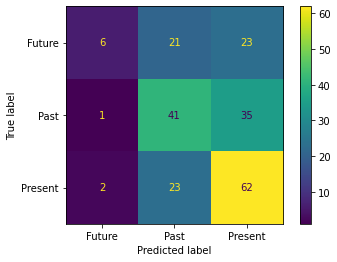

              precision    recall  f1-score   support

           0       0.67      0.12      0.20        50
           1       0.48      0.53      0.51        77
           2       0.52      0.71      0.60        87

    accuracy                           0.51       214
   macro avg       0.56      0.46      0.44       214
weighted avg       0.54      0.51      0.47       214



In [384]:
_ = evaluate_random_forest(rf_model_0, X_train_0, y_train_0, X_test_0, y_test_0, name="Model 0")

#### Evaluation: Logistic Regression Model 0

In [405]:
best_parameters = scores[1]["best_params"]
best_parameters

{'C': 1, 'max_iter': 200, 'penalty': 'l1', 'solver': 'liblinear'}

In [388]:
lr_model_0 = LogisticRegression(random_state=18,
                                C=best_parameters['C'],
                                solver=best_parameters['solver'],
                                max_iter=best_parameters['max_iter'],
                                penalty=best_parameters['penalty'])

lr_model_0.fit(X_train_0, y_train_0)

LogisticRegression(C=1, max_iter=200, penalty='l1', random_state=18,
                   solver='liblinear')

Evaluation Logistic Regression Classifier: Model 0
--------------------------------------------------------------------------------
Mean accuracy score on training set 0.5783410138248848
Mean accuracy score on test set 0.514018691588785


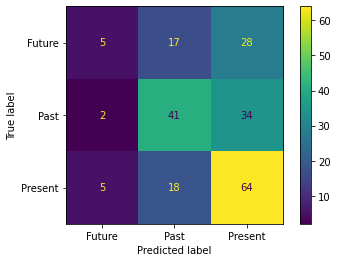

              precision    recall  f1-score   support

           0       0.42      0.10      0.16        50
           1       0.54      0.53      0.54        77
           2       0.51      0.74      0.60        87

    accuracy                           0.51       214
   macro avg       0.49      0.46      0.43       214
weighted avg       0.50      0.51      0.47       214



In [395]:
_ = evaluate_lr(lr_model_0, X_train_0, y_train_0, X_test_0, y_test_0, name="Model 0")

#### Evaluation: Naive Bayes Model 0

In [399]:
best_parameters = scores[2]["best_params"]
best_parameters

{'alpha': 0.7, 'fit_prior': False}

In [403]:
nb_model_0 = MultinomialNB(alpha=best_parameters['alpha'],
                           fit_prior=best_parameters["fit_prior"])

nb_model_0.fit(X_train_0, y_train_0)

MultinomialNB(alpha=0.7, fit_prior=False)

Evaluation Naive Bayes Classifier: Model 0
--------------------------------------------------------------------------------
Mean accuracy score on training set 0.5276497695852534
Mean accuracy score on test set 0.4953271028037383


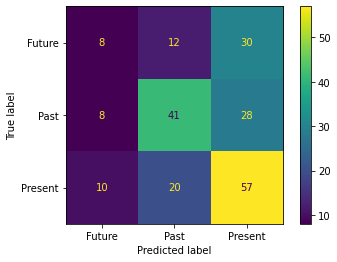

              precision    recall  f1-score   support

           0       0.31      0.16      0.21        50
           1       0.56      0.53      0.55        77
           2       0.50      0.66      0.56        87

    accuracy                           0.50       214
   macro avg       0.45      0.45      0.44       214
weighted avg       0.48      0.50      0.48       214



In [404]:
_ = evaluate_nb(nb_model_0, X_train_0, y_train_0, X_test_0, y_test_0, name="Model 0")

#### Evaluation: SVM Model 0

In [407]:
best_parameters = scores[3]["best_params"]
best_parameters

{'C': 1000, 'gamma': 0.001, 'kernel': 'linear'}

In [410]:
svm_model_0 = SVC(C=best_parameters['C'],
                  gamma=best_parameters['gamma'],
                  kernel=best_parameters["kernel"])

svm_model_0.fit(X_train_0, y_train_0)

SVC(C=1000, gamma=0.001, kernel='linear')

Evaluation SVM Classifier: Model 0
--------------------------------------------------------------------------------
Mean accuracy score on training set 0.5898617511520737
Mean accuracy score on test set 0.5280373831775701


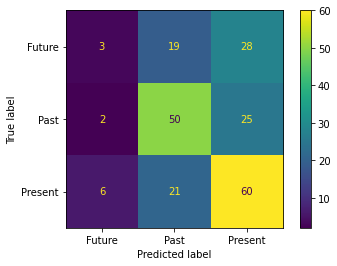

              precision    recall  f1-score   support

           0       0.27      0.06      0.10        50
           1       0.56      0.65      0.60        77
           2       0.53      0.69      0.60        87

    accuracy                           0.53       214
   macro avg       0.45      0.47      0.43       214
weighted avg       0.48      0.53      0.48       214



In [411]:
_ = evaluate_svm(svm_model_0, X_train_0, y_train_0, X_test_0, y_test_0, name="Model 0")

### Model 1. (All features) simple_features + tfidf + w2v

#### Training: Model 1

In [523]:
X_1, y_1, X_train_1, y_train_1, X_test_1, y_test_1 = train_test(features_1, 
                                                                scale_enabled=True, 
                                                                encode_enabled=True)

label_mapping = {'Future': 0, 'Past': 1, 'Present': 2}

Label mapping {'Future': 0, 'Past': 1, 'Present': 2}
Successfully created train and test sets.


In [526]:
scores = []

for model_name, mp in model_params.items():
    clf = GridSearchCV(mp['model'], mp['params'], scoring="f1_weighted", cv = 10, n_jobs=-1, verbose=1)
    
    print(mp['model'])
    print('\nfitting...')
    clf.fit(X_train_1, y_train_1)
    scores.append({
        'model' : model_name,
        'best_score' : clf.best_score_,
        'best_params' : clf.best_params_
    })
    print('\nscore is appended\n')

RandomForestClassifier()

fitting...
Fitting 10 folds for each of 60 candidates, totalling 600 fits

score is appended

LogisticRegression()

fitting...
Fitting 10 folds for each of 48 candidates, totalling 480 fits


/Users/gbaldonado/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/gbaldonado/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.


score is appended

MultinomialNB()

fitting...
Fitting 10 folds for each of 12 candidates, totalling 120 fits

score is appended

SVC()

fitting...
Fitting 10 folds for each of 16 candidates, totalling 160 fits

score is appended



In [527]:
scores

[{'model': 'random_forest',
  'best_score': 0.5088922981631943,
  'best_params': {'max_features': 8,
   'min_samples_leaf': 1,
   'n_estimators': 100}},
 {'model': 'logistics_regression',
  'best_score': 0.6039343511354601,
  'best_params': {'C': 1,
   'max_iter': 200,
   'penalty': 'l2',
   'solver': 'liblinear'}},
 {'model': 'MultinomialNB',
  'best_score': 0.6430461126944698,
  'best_params': {'alpha': 1.1, 'fit_prior': False}},
 {'model': 'SVM',
  'best_score': 0.6126330200817317,
  'best_params': {'C': 1, 'gamma': 0.001, 'kernel': 'linear'}}]

#### Evaluation: Random Forest Model 1

In [528]:
best_parameters = scores[0]["best_params"]
best_parameters

{'max_features': 8, 'min_samples_leaf': 1, 'n_estimators': 100}

In [529]:
rf_model_1 = RandomForestClassifier(random_state=18,
                                    max_features=best_parameters['max_features'],
                                    min_samples_leaf=best_parameters['min_samples_leaf'],
                                    n_estimators=best_parameters['n_estimators'])

rf_model_1.fit(X_train_1, y_train_1)

RandomForestClassifier(max_features=8, random_state=18)

Evaluation Random Forest Classifier: Model 1
--------------------------------------------------------------------------------
Mean accuracy score on training set 1.0
Mean accuracy score on test set 0.5607476635514018


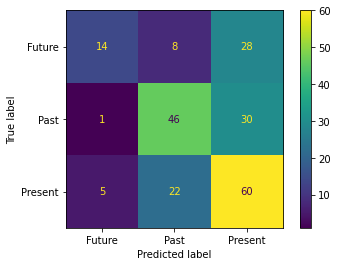

              precision    recall  f1-score   support

           0       0.70      0.28      0.40        50
           1       0.61      0.60      0.60        77
           2       0.51      0.69      0.59        87

    accuracy                           0.56       214
   macro avg       0.60      0.52      0.53       214
weighted avg       0.59      0.56      0.55       214



In [530]:
_ = evaluate_random_forest(rf_model_1, X_train_1, y_train_1, X_test_1, y_test_1, name="Model 1")

#### Evaluation: Logistic Regression Model 1

In [531]:
best_parameters = scores[1]["best_params"]
best_parameters

{'C': 1, 'max_iter': 200, 'penalty': 'l2', 'solver': 'liblinear'}

In [532]:
lr_model_1 = LogisticRegression(random_state=18,
                                C=best_parameters['C'],
                                solver=best_parameters['solver'],
                                max_iter=best_parameters['max_iter'],
                                penalty=best_parameters['penalty'])

lr_model_1.fit(X_train_1, y_train_1)

LogisticRegression(C=1, max_iter=200, random_state=18, solver='liblinear')

Evaluation Logistic Regression Classifier: Model 1
--------------------------------------------------------------------------------
Mean accuracy score on training set 0.7788018433179723
Mean accuracy score on test set 0.5420560747663551


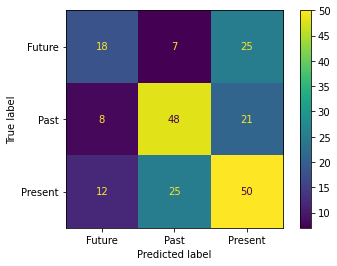

              precision    recall  f1-score   support

           0       0.47      0.36      0.41        50
           1       0.60      0.62      0.61        77
           2       0.52      0.57      0.55        87

    accuracy                           0.54       214
   macro avg       0.53      0.52      0.52       214
weighted avg       0.54      0.54      0.54       214



In [533]:
_ = evaluate_lr(lr_model_1, X_train_1, y_train_1, X_test_1, y_test_1, name="Model 1")

#### Evaluation: Naive Bayes Model 1

In [544]:
best_parameters = scores[2]["best_params"]
best_parameters

{'alpha': 1.1, 'fit_prior': False}

In [545]:
nb_model_1 = MultinomialNB(alpha=best_parameters['alpha'],
                           fit_prior=best_parameters["fit_prior"])

nb_model_1.fit(X_train_1, y_train_1)

MultinomialNB(alpha=1.1, fit_prior=False)

Evaluation Naive Bayes Classifier: Model 1
--------------------------------------------------------------------------------
Mean accuracy score on training set 0.6912442396313364
Mean accuracy score on test set 0.5887850467289719


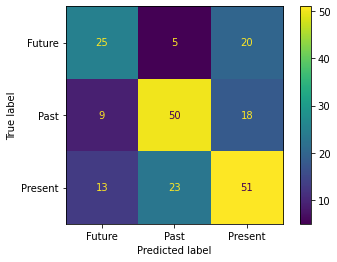

              precision    recall  f1-score   support

           0       0.53      0.50      0.52        50
           1       0.64      0.65      0.65        77
           2       0.57      0.59      0.58        87

    accuracy                           0.59       214
   macro avg       0.58      0.58      0.58       214
weighted avg       0.59      0.59      0.59       214



In [546]:
_ = evaluate_nb(nb_model_1, X_train_1, y_train_1, X_test_1, y_test_1, name="Model 1")

#### Evaluation: SVM Model 1

In [537]:
best_parameters = scores[3]["best_params"]
best_parameters

{'C': 1, 'gamma': 0.001, 'kernel': 'linear'}

In [538]:
svm_model_1 = SVC(C=best_parameters['C'],
                  gamma=best_parameters['gamma'],
                  kernel=best_parameters["kernel"])

svm_model_1.fit(X_train_1, y_train_1)

SVC(C=1, gamma=0.001, kernel='linear')

Evaluation SVM Classifier: Model 1
--------------------------------------------------------------------------------
Mean accuracy score on training set 0.8087557603686636
Mean accuracy score on test set 0.5280373831775701


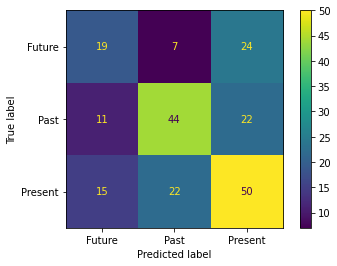

              precision    recall  f1-score   support

           0       0.42      0.38      0.40        50
           1       0.60      0.57      0.59        77
           2       0.52      0.57      0.55        87

    accuracy                           0.53       214
   macro avg       0.52      0.51      0.51       214
weighted avg       0.53      0.53      0.53       214



In [539]:
_ = evaluate_svm(svm_model_1, X_train_1, y_train_1, X_test_1, y_test_1, name="Model 1")

### Model 2. simple_features + w2v

#### Training: Model 2

In [486]:
X_2, y_2, X_train_2, y_train_2, X_test_2, y_test_2 = train_test(features_2, 
                                                                scale_enabled=True, 
                                                                encode_enabled=True)

label_mapping = {'Future': 0, 'Past': 1, 'Present': 2}

Label mapping {'Future': 0, 'Past': 1, 'Present': 2}
Successfully created train and test sets.


In [487]:
scores = []

for model_name, mp in model_params.items():
    clf = GridSearchCV(mp['model'], mp['params'], scoring="f1_weighted", cv = 10, n_jobs=-1, verbose=1)
    
    print(mp['model'])
    print('\nfitting...')
    clf.fit(X_train_2, y_train_2)
    scores.append({
        'model' : model_name,
        'best_score' : clf.best_score_,
        'best_params' : clf.best_params_
    })
    print('\nscore is appended\n')

RandomForestClassifier()

fitting...
Fitting 10 folds for each of 60 candidates, totalling 600 fits

score is appended

LogisticRegression()

fitting...
Fitting 10 folds for each of 48 candidates, totalling 480 fits


/Users/gbaldonado/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/gbaldonado/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.


score is appended

MultinomialNB()

fitting...
Fitting 10 folds for each of 12 candidates, totalling 120 fits

score is appended

SVC()

fitting...
Fitting 10 folds for each of 16 candidates, totalling 160 fits

score is appended



In [488]:
scores

[{'model': 'random_forest',
  'best_score': 0.5039997209707995,
  'best_params': {'max_features': 8,
   'min_samples_leaf': 2,
   'n_estimators': 200}},
 {'model': 'logistics_regression',
  'best_score': 0.5401228165853433,
  'best_params': {'C': 1,
   'max_iter': 400,
   'penalty': 'l2',
   'solver': 'lbfgs'}},
 {'model': 'MultinomialNB',
  'best_score': 0.5142881286471915,
  'best_params': {'alpha': 1.5, 'fit_prior': True}},
 {'model': 'SVM',
  'best_score': 0.5024462765449853,
  'best_params': {'C': 1, 'gamma': 0.001, 'kernel': 'linear'}}]

#### Evaluation: Random Forest Model 2

In [489]:
best_parameters = scores[0]["best_params"]
best_parameters

{'max_features': 8, 'min_samples_leaf': 2, 'n_estimators': 200}

In [490]:
rf_model_2 = RandomForestClassifier(random_state=18,
                                    max_features=best_parameters['max_features'],
                                    min_samples_leaf=best_parameters['min_samples_leaf'],
                                    n_estimators=best_parameters['n_estimators'])

rf_model_2.fit(X_train_2, y_train_2)

RandomForestClassifier(max_features=8, min_samples_leaf=2, n_estimators=200,
                       random_state=18)

Evaluation Random Forest Classifier: Model 2
--------------------------------------------------------------------------------
Mean accuracy score on training set 1.0
Mean accuracy score on test set 0.5093457943925234


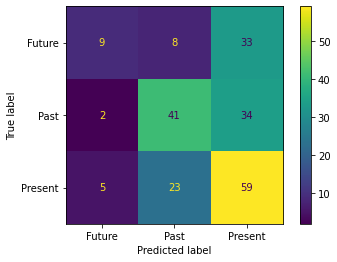

              precision    recall  f1-score   support

           0       0.56      0.18      0.27        50
           1       0.57      0.53      0.55        77
           2       0.47      0.68      0.55        87

    accuracy                           0.51       214
   macro avg       0.53      0.46      0.46       214
weighted avg       0.53      0.51      0.49       214



In [491]:
_ = evaluate_random_forest(rf_model_2, X_train_2, y_train_2, X_test_2, y_test_2, name="Model 2")

#### Evaluation: Logistic Regression Model 2

In [492]:
best_parameters = scores[1]["best_params"]
best_parameters

{'C': 1, 'max_iter': 400, 'penalty': 'l2', 'solver': 'lbfgs'}

In [493]:
lr_model_2 = LogisticRegression(random_state=18,
                                C=best_parameters['C'],
                                solver=best_parameters['solver'],
                                max_iter=best_parameters['max_iter'],
                                penalty=best_parameters['penalty'])

lr_model_2.fit(X_train_2, y_train_2)

LogisticRegression(C=1, max_iter=400, random_state=18)

Evaluation Logistic Regression Classifier: Model 2
--------------------------------------------------------------------------------
Mean accuracy score on training set 0.7027649769585254
Mean accuracy score on test set 0.5186915887850467


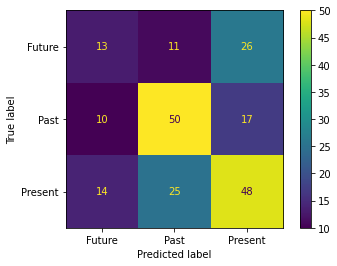

              precision    recall  f1-score   support

           0       0.35      0.26      0.30        50
           1       0.58      0.65      0.61        77
           2       0.53      0.55      0.54        87

    accuracy                           0.52       214
   macro avg       0.49      0.49      0.48       214
weighted avg       0.51      0.52      0.51       214



In [494]:
_ = evaluate_lr(lr_model_2, X_train_2, y_train_2, X_test_2, y_test_2, name="Model 2")

#### Evaluation: Naive Bayes Model 2

In [495]:
best_parameters = scores[2]["best_params"]
best_parameters

{'alpha': 1.5, 'fit_prior': True}

In [496]:
nb_model_2 = MultinomialNB(alpha=best_parameters['alpha'],
                           fit_prior=best_parameters["fit_prior"])

nb_model_2.fit(X_train_2, y_train_2)

MultinomialNB(alpha=1.5)

Evaluation Naive Bayes Classifier: Model 2
--------------------------------------------------------------------------------
Mean accuracy score on training set 0.5898617511520737
Mean accuracy score on test set 0.5420560747663551


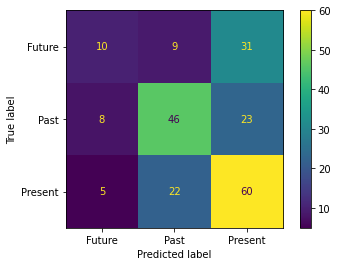

              precision    recall  f1-score   support

           0       0.43      0.20      0.27        50
           1       0.60      0.60      0.60        77
           2       0.53      0.69      0.60        87

    accuracy                           0.54       214
   macro avg       0.52      0.50      0.49       214
weighted avg       0.53      0.54      0.52       214



In [497]:
_ = evaluate_nb(nb_model_2, X_train_2, y_train_2, X_test_2, y_test_2, name="Model 2")

#### Evaluation: SVM Model 2

In [498]:
best_parameters = scores[3]["best_params"]
best_parameters

{'C': 1, 'gamma': 0.001, 'kernel': 'linear'}

In [499]:
svm_model_2 = SVC(C=best_parameters['C'],
                  gamma=best_parameters['gamma'],
                  kernel=best_parameters["kernel"])

svm_model_2.fit(X_train_2, y_train_2)

SVC(C=1, gamma=0.001, kernel='linear')

Evaluation SVM Classifier: Model 2
--------------------------------------------------------------------------------
Mean accuracy score on training set 0.7350230414746544
Mean accuracy score on test set 0.5373831775700935


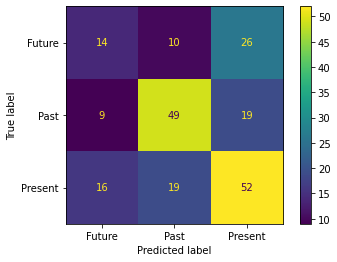

              precision    recall  f1-score   support

           0       0.36      0.28      0.31        50
           1       0.63      0.64      0.63        77
           2       0.54      0.60      0.57        87

    accuracy                           0.54       214
   macro avg       0.51      0.50      0.50       214
weighted avg       0.53      0.54      0.53       214



In [500]:
_ = evaluate_svm(svm_model_2, X_train_2, y_train_2, X_test_2, y_test_2, name="Model 2")

### Model 3. simple_features + tfidf

#### Training: Model 3

In [501]:
X_3, y_3, X_train_3, y_train_3, X_test_3, y_test_3 = train_test(features_3, 
                                                                scale_enabled=True, 
                                                                encode_enabled=True)

label_mapping = {'Future': 0, 'Past': 1, 'Present': 2}

Label mapping {'Future': 0, 'Past': 1, 'Present': 2}
Successfully created train and test sets.


In [502]:
scores = []

for model_name, mp in model_params.items():
    clf = GridSearchCV(mp['model'], mp['params'], scoring="f1_weighted", cv = 10, n_jobs=-1, verbose=1)
    
    print(mp['model'])
    print('\nfitting...')
    clf.fit(X_train_3, y_train_3)
    scores.append({
        'model' : model_name,
        'best_score' : clf.best_score_,
        'best_params' : clf.best_params_
    })
    print('\nscore is appended\n')

RandomForestClassifier()

fitting...
Fitting 10 folds for each of 60 candidates, totalling 600 fits

score is appended

LogisticRegression()

fitting...
Fitting 10 folds for each of 48 candidates, totalling 480 fits


/Users/gbaldonado/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/gbaldonado/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.


score is appended

MultinomialNB()

fitting...
Fitting 10 folds for each of 12 candidates, totalling 120 fits

score is appended

SVC()

fitting...
Fitting 10 folds for each of 16 candidates, totalling 160 fits

score is appended



In [503]:
scores

[{'model': 'random_forest',
  'best_score': 0.5820750056301696,
  'best_params': {'max_features': 4,
   'min_samples_leaf': 1,
   'n_estimators': 500}},
 {'model': 'logistics_regression',
  'best_score': 0.6570216284880572,
  'best_params': {'C': 100,
   'max_iter': 200,
   'penalty': 'l2',
   'solver': 'liblinear'}},
 {'model': 'MultinomialNB',
  'best_score': 0.6486571873057152,
  'best_params': {'alpha': 0.5, 'fit_prior': False}},
 {'model': 'SVM',
  'best_score': 0.6388402087754717,
  'best_params': {'C': 10, 'gamma': 0.001, 'kernel': 'linear'}}]

#### Evaluation: Random Forest Model 3

In [504]:
best_parameters = scores[0]["best_params"]
best_parameters

{'max_features': 4, 'min_samples_leaf': 1, 'n_estimators': 500}

In [506]:
rf_model_3 = RandomForestClassifier(random_state=18,
                                    max_features=best_parameters['max_features'],
                                    min_samples_leaf=best_parameters['min_samples_leaf'],
                                    n_estimators=best_parameters['n_estimators'])

rf_model_3.fit(X_train_3, y_train_3)

RandomForestClassifier(max_features=4, n_estimators=500, random_state=18)

Evaluation Random Forest Classifier: Model 3
--------------------------------------------------------------------------------
Mean accuracy score on training set 1.0
Mean accuracy score on test set 0.5233644859813084


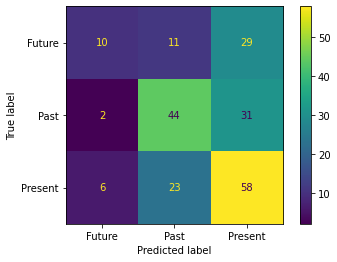

              precision    recall  f1-score   support

           0       0.56      0.20      0.29        50
           1       0.56      0.57      0.57        77
           2       0.49      0.67      0.57        87

    accuracy                           0.52       214
   macro avg       0.54      0.48      0.48       214
weighted avg       0.53      0.52      0.50       214



In [507]:
_ = evaluate_random_forest(rf_model_3, X_train_3, y_train_3, X_test_3, y_test_3, name="Model 3")

#### Evaluation: Logistic Regression Model 3

In [508]:
best_parameters = scores[1]["best_params"]
best_parameters

{'C': 100, 'max_iter': 200, 'penalty': 'l2', 'solver': 'liblinear'}

In [509]:
lr_model_3 = LogisticRegression(random_state=18,
                                C=best_parameters['C'],
                                solver=best_parameters['solver'],
                                max_iter=best_parameters['max_iter'],
                                penalty=best_parameters['penalty'])

lr_model_3.fit(X_train_3, y_train_3)

LogisticRegression(C=100, max_iter=200, random_state=18, solver='liblinear')

Evaluation Logistic Regression Classifier: Model 3
--------------------------------------------------------------------------------
Mean accuracy score on training set 0.7304147465437788
Mean accuracy score on test set 0.5327102803738317


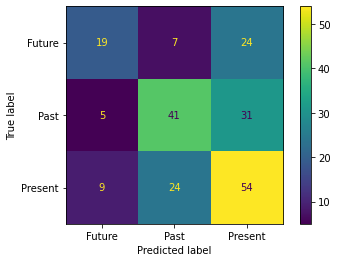

              precision    recall  f1-score   support

           0       0.58      0.38      0.46        50
           1       0.57      0.53      0.55        77
           2       0.50      0.62      0.55        87

    accuracy                           0.53       214
   macro avg       0.55      0.51      0.52       214
weighted avg       0.54      0.53      0.53       214



In [510]:
_ = evaluate_lr(lr_model_3, X_train_3, y_train_3, X_test_3, y_test_3, name="Model 3")

#### Evaluation: Naive Bayes Model 3

In [511]:
best_parameters = scores[2]["best_params"]
best_parameters

{'alpha': 0.5, 'fit_prior': False}

In [512]:
nb_model_3 = MultinomialNB(alpha=best_parameters['alpha'],
                           fit_prior=best_parameters["fit_prior"])

nb_model_3.fit(X_train_3, y_train_3)

MultinomialNB(alpha=0.5, fit_prior=False)

Evaluation Naive Bayes Classifier: Model 3
--------------------------------------------------------------------------------
Mean accuracy score on training set 0.684331797235023
Mean accuracy score on test set 0.5700934579439252


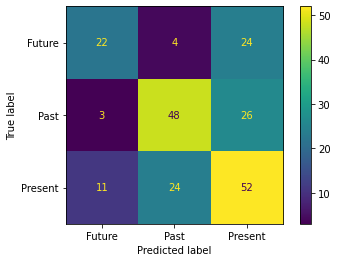

              precision    recall  f1-score   support

           0       0.61      0.44      0.51        50
           1       0.63      0.62      0.63        77
           2       0.51      0.60      0.55        87

    accuracy                           0.57       214
   macro avg       0.58      0.55      0.56       214
weighted avg       0.58      0.57      0.57       214



In [513]:
_ = evaluate_nb(nb_model_3, X_train_3, y_train_3, X_test_3, y_test_3, name="Model 3")

#### Evaluation: SVM Model 3

In [514]:
best_parameters = scores[3]["best_params"]
best_parameters

{'C': 10, 'gamma': 0.001, 'kernel': 'linear'}

In [515]:
svm_model_3 = SVC(C=best_parameters['C'],
                  gamma=best_parameters['gamma'],
                  kernel=best_parameters["kernel"])

svm_model_3.fit(X_train_3, y_train_3)

SVC(C=10, gamma=0.001, kernel='linear')

Evaluation SVM Classifier: Model 3
--------------------------------------------------------------------------------
Mean accuracy score on training set 0.7142857142857143
Mean accuracy score on test set 0.5327102803738317


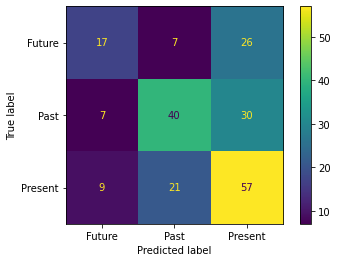

              precision    recall  f1-score   support

           0       0.52      0.34      0.41        50
           1       0.59      0.52      0.55        77
           2       0.50      0.66      0.57        87

    accuracy                           0.53       214
   macro avg       0.54      0.50      0.51       214
weighted avg       0.54      0.53      0.53       214



In [516]:
_ = evaluate_svm(svm_model_3, X_train_3, y_train_3, X_test_3, y_test_3, name="Model 3")

### Model Comparisons

## Evaluation of Naive Bayes Model 1

In [552]:
def get_X_with_doc(engineered_df, scale_enabled=False, encode_enabled=False):
    y = engineered_df["label"]
    X = engineered_df.drop(columns=["label"], axis=1)
   
    
    if scale_enabled == True:
        X = scale(X)
        
            
    if encode_enabled == True:
        encoded_df = encode_categorical_feat(engineered_df)
        y = encoded_df["label"]
        
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.33, random_state=42)

    X_train.reset_index(inplace=True, drop=True)
    X_test.reset_index(inplace=True, drop=True)
    y_train.reset_index(inplace=True, drop=True)
    y_test.reset_index(inplace=True, drop=True)
    
    print("Successfully created train and test sets.")
    
    return X, y, X_train, y_train, X_test, y_test

In [554]:
_, _, _, _, X_test_with_doc, y_test_with_doc = get_X_with_doc(features_1, 
                                                                scale_enabled=False, 
                                                                encode_enabled=True)

label_mapping = {'Future': 0, 'Past': 1, 'Present': 2}

Label mapping {'Future': 0, 'Past': 1, 'Present': 2}
Successfully created train and test sets.


In [556]:
X_test_1

,neg_polarity,neu_polarity,pos_polarity,com_polarity,subjectivity,count_time_expressions,futuristic,past,past present,present,...,embedding290,embedding291,embedding292,embedding293,embedding294,embedding295,embedding296,embedding297,embedding298,embedding299
0,0.307400,0.728950,0.085352,0.264005,0.00,0.000,0.0,0.000000,0.0,0.50,...,0.763950,0.576698,0.897735,0.390377,0.260326,0.463392,1.000000,0.756953,0.907270,0.386956
1,0.263757,0.584775,0.254902,0.742180,0.46,0.000,0.0,0.000000,0.5,0.25,...,0.454210,0.715203,0.843966,0.539755,0.413912,0.387817,0.503503,0.617838,0.547666,0.540980
2,0.455408,0.600923,0.122261,0.110560,0.65,0.000,0.0,0.000000,0.0,0.00,...,0.558538,0.680168,0.742005,0.316647,0.297040,0.340007,0.660401,0.788009,0.766425,0.485186
3,0.406072,0.753172,0.000000,0.050245,0.90,0.000,0.0,0.000000,0.0,0.25,...,0.455896,0.541494,0.765572,0.646354,0.402356,0.495549,0.442337,0.649946,0.662880,0.400131
4,0.000000,0.866205,0.133795,0.683143,0.20,0.125,0.0,0.000000,0.0,0.00,...,0.385843,0.814044,0.515469,0.436891,0.331671,0.388559,0.458484,0.649551,0.689748,0.170818
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
209,0.223909,0.672434,0.191465,0.724647,0.62,0.125,0.0,0.000000,0.0,0.00,...,0.630939,0.497310,0.628571,0.670241,0.325391,0.387110,0.308294,0.270096,0.411011,0.309678
210,0.407970,0.752018,0.000000,0.166990,0.47,0.000,0.0,0.000000,0.0,0.00,...,0.697264,0.277027,0.711209,0.661242,0.421567,0.337944,0.509100,0.471885,0.483475,0.435514
211,0.096774,0.791234,0.149942,0.759507,0.35,0.000,0.0,0.000000,0.0,0.00,...,0.554114,0.754004,0.787653,0.555313,0.536286,0.310352,0.363030,0.616450,0.507549,0.522771
212,0.392789,0.580161,0.181084,0.150020,0.69,0.250,0.0,0.333333,0.0,0.50,...,0.652300,0.443528,0.507832,0.552640,0.354213,0.439058,0.735641,0.479633,0.427507,0.177447


Evaluation Naive Bayes Classifier: Model 1
--------------------------------------------------------------------------------
Mean accuracy score on training set 0.6912442396313364
Mean accuracy score on test set 0.5887850467289719


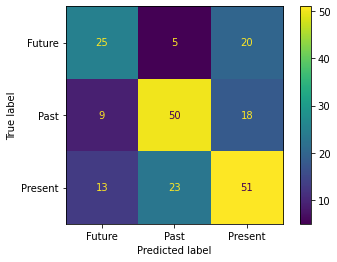

              precision    recall  f1-score   support

           0       0.53      0.50      0.52        50
           1       0.64      0.65      0.65        77
           2       0.57      0.59      0.58        87

    accuracy                           0.59       214
   macro avg       0.58      0.58      0.58       214
weighted avg       0.59      0.59      0.59       214



In [548]:
y_pred = evaluate_nb(nb_model_1, X_train_1, y_train_1, X_test_1, y_test_1, name="Model 1")

In [558]:
def get_result_frames(prediction, ground_truth):
    results = {"doc": X_test_with_doc["doc"], "clean": X_test_with_doc["clean"], "tokens": X_test_with_doc["tokens"], "prediction": prediction, "ground_truth": ground_truth}
    results = pd.DataFrame(results)
    
    return results


In [562]:
results = get_result_frames(y_pred, y_test_1)
results

,doc,clean,tokens,prediction,ground_truth
0,"It will be just don’t use any substance I learned I even abused weed if that makes sense, I would let it control me just like opiates. Because I have no self control",will be just dont use any substance learned even abused weed if makes sense would let control just like opiates because have no self control,"[will, be, just, dont, use, any, substance, learned, even, abused, weed, if, makes, sense, would, let, control, just, like, opiates, because, have, no, self, control]",0,0
1,You dont need to feel guilt or shame. You turned that stuff down. Good job. You're still early in the ballgame. Cravings are normal and natural. They'll get better.,dont need to feel guilt or shame turned stuff down good job are still early in the ballgame cravings are normal and natural will get better,"[dont, need, to, feel, guilt, or, shame, turned, stuff, down, good, job, are, still, early, in, the, ballgame, cravings, are, normal, and, natural, will, get, better]",2,1
2,I want to go do this but I’m so self conscious cause I would have no idea what to do when I got into a gym. Like what exercises to do without looking like an idiot,want to go do but im so self conscious cause would have no idea to do when got into a gym like exercises to do without looking like an idiot,"[want, to, go, do, but, im, so, self, conscious, cause, would, have, no, idea, to, do, when, got, into, a, gym, like, exercises, to, do, without, looking, like, an, idiot]",0,0
3,Do you think it helped rather than jumping off from the start? I know it will be painful either way but I think I might not do it just so I can avoid felling shitty for longer and get the acute withdrawals over with.,do think helped rather than jumping off from the start know will be painful either way but think might not do just so can avoid felling shitty for longer and get the acute withdrawals over with,"[do, think, helped, rather, than, jumping, off, from, the, start, know, will, be, painful, either, way, but, think, might, not, do, just, so, can, avoid, felling, shitty, for, longer, and, get, the, acute, withdrawals, over, with]",0,0
4,Day 6 being sober \n\nIt feels like cocaine. I got so much power I don’t know what to do. Gonna hit the gym 💪,day 6 being sober feels like cocaine got so much power dont know to do gonna hit the gym,"[day, 6, being, sober, feels, like, cocaine, got, so, much, power, dont, know, to, do, gonna, hit, the, gym]",2,2
...,...,...,...,...,...
209,"i’m glad you were found and made it, for the sake of not only you but your loved ones as well. he’s the second person in my life that i’ve lost to a fent overdose this year and seeing the impact it’s had on everyone has been very disheartening",im glad were found and made for the sake of not only but loved ones as well hes the second person in life ive lost to a fent overdose year and seeing the impact had on everyone has been very disheartening,"[im, glad, were, found, and, made, for, the, sake, of, not, only, but, loved, ones, as, well, hes, the, second, person, in, life, ive, lost, to, a, fent, overdose, year, and, seeing, the, impact, had, on, everyone, has, been, very, disheartening]",1,1
210,I'm right there with you. I also have a mortgage pay and 2 young children to provide for.. no time for rehab. Gotta keep grinding or I'll lose everything..,am right there with also have a mortgage pay and 2 young children to provide for no time for rehab gotta keep grinding or will lose everything,"[am, right, there, with, also, have, a, mortgage, pay, and, 2, young, children, to, provide, for, no, time, for, rehab, gotta, keep, grinding, or, will, lose, everything]",2,0
211,Yes. I’m miserable without drugs. I can stay sober for x amount of time but will always go back. 12 steps promising a spiritual experience and a new mindset and way of life. Drugs are but a symptom of our spiritual sickness.,yes im miserable without drugs can stay sober for x amount of time but will always go back 12 steps pr

In [573]:
def get_cm_frames(result):
    # Grab sentences by TP,TN, FP, FN

    TP = result[result["prediction"] == result["ground_truth"]]
    
    TP0 = TP[(TP["prediction"] == 0) & (TP["ground_truth"] == 0)]
    TP1 = TP[(TP["prediction"] == 1) & (TP["ground_truth"] == 1)]
    TP2 = TP[(TP["prediction"] == 2) & (TP["ground_truth"] == 2)]
    
    E = result[result["prediction"] != result["ground_truth"]]
    
    # Misclassified Class 0s
    E01 = E[(E["prediction"] == 1) & (E["ground_truth"] == 0)]
    E02 = E[(E["prediction"] == 2) & (E["ground_truth"] == 0)]
    
    # Misclassified Class 1s
    E10 = E[(E["prediction"] == 0) & (E["ground_truth"] == 1)]
    E12 = E[(E["prediction"] == 2) & (E["ground_truth"] == 1)]
    
    # Misclassified Class 2s
    E20 = E[(E["prediction"] == 0) & (E["ground_truth"] == 2)]
    E21 = E[(E["prediction"] == 1) & (E["ground_truth"] == 2)]

    cms_dfs = {'TP': TP, 
               'TP0':TP0, 
               'TP1': TP1, 
               'TP2': TP2, 
               'E': E, 
               'E01': E01,
               'E02': E02,
               'E10': E10,
               'E12': E12,
               'E20': E20,
               'E21': E21,
              }
    
    return cms_dfs

In [574]:
model_1_cms_frames = get_cm_frames(results)

In [575]:
for k,v in model_1_cms_frames.items():
    v.to_csv(f"{k}.csv", index=False)